# Quantics TCI of univariate function

This tutorial shows the QTT quantics approach to interpolate 1-dimensional functions.

The first line in the following code block imports the packages xfacpy as well as standard Python packages for numerical computations and plotting (lines 3-5).

In [1]:
import xfacpy

import numpy as np
from math import cos, sin, exp, sqrt, log, atan
import matplotlib.pyplot as plt

## Example 1

The first example is taken from Fig. 1 in [Ritter2024](https://arxiv.org/abs/2303.11819).

$$
f(x) = \cos\left(\frac{x}{b}\right) \cos\left(\frac{x}{4\sqrt{5}b}\right) e^{-x^2} + 2e^{-x},
$$

where $b = 2^{-30}$. In Python, this can be written as:

In [2]:
def f(x):
    b = 2**(-30)
    return cos(x / b) * cos(x / (4 * sqrt(5) * b)) * exp(-x**2) + 2 * exp(-x)

def fcaching(x): # this is just to plot later the sampled points
    y = f(x)
    fcaching.sampled[x] = y    
    return y
fcaching.sampled = {}

Let's examine the behaviour of $f(x)$. This function involves structure on widely different scales: rapid, incommensurate oscillations and a slowly decaying envelope.
Below we plot $f(x)$ in interval $x \in [0, 2^{-23})$ (upper panel) and $x \in (0, 3]$ (lower panel):

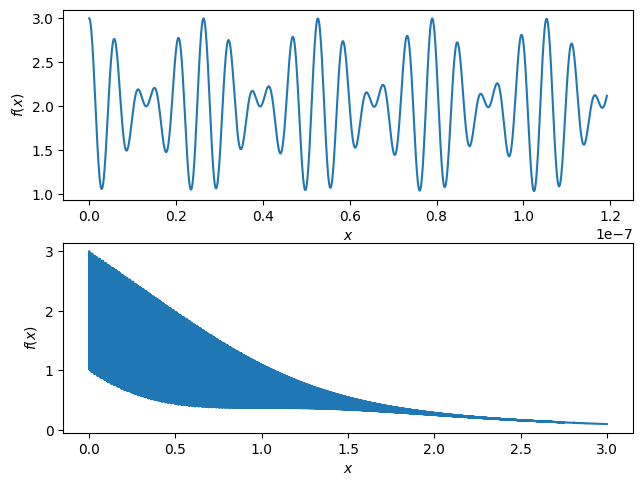

In [3]:
fig, ax = plt.subplots(2)
fig.tight_layout(pad=1.0)

xs = np.linspace(0, 2.0**(-23), 1000)
ax[0].plot(xs, [f(x) for x in xs])

xs = np.linspace(0, 3, 100000)
ax[1].plot(xs, [f(x) for x in xs])

for axis in ax:
    axis.set_xlabel(r'$x$')
    axis.set_ylabel(r'$f(x)$')
plt.show()

### QTT representation

A quantics grid is an uniform grid with $2^R$ points in [a,b):

$x_i=a+i\Delta$,

where $\Delta = (b -a)/2^R $ and $i=0,1,...,2^R-1 $.

The function $f$ is mapped to a tensor with $R$ legs in the following way. The binary digits $\{\sigma_i\}$ of $i$ are used as indices of the tensor $F$ defined by:
$$
F(\{\sigma_i\})=f(x_i)
$$


Let's construct a QTT representation of our $f$ on the domain $[0,3)$ using $2^{40}$ points.

In [4]:
qgrid = xfacpy.QuanticsGrid(a=0.0, b=3.0, nBit=40)  # build the quantics grid
args = xfacpy.TensorCI2Param()                      # fix the max bond dimension
args.bondDim = 15
ci = xfacpy.QTensorCI(f1d=fcaching, qgrid=qgrid, args=args)  # construct a tci of the quantics tensor
while not ci.isDone():
    ci.iterate()

### Check the convergence
Here, we've created the object `ci` which is both a `QTensorCI` and a `TensorCI2`.
The first thing to check is the convergence, ie, how the pivot error decrease.

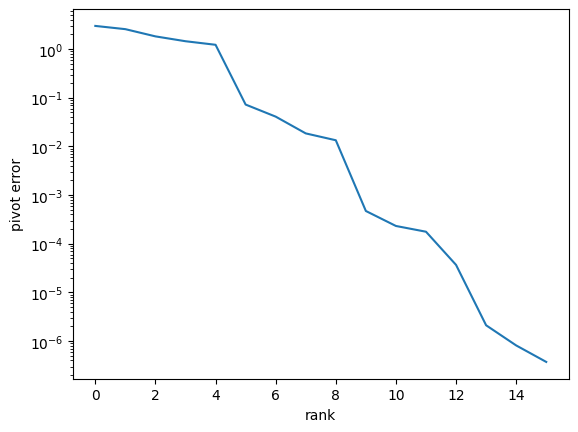

In [5]:
plt.xlabel("rank")
plt.ylabel("pivot error")
plt.yscale("log")
plt.plot(ci.pivotError);

### Plotting the approximation
Let's get the approximated function `qtt`. It can be saved/loaded to a hard disc, evaluated, and plotted:

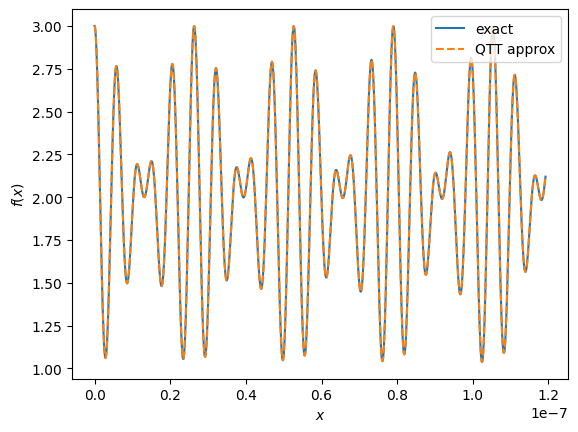

In [6]:
qtt = ci.get_qtt()  # the actual function approximating f

xs = np.linspace(0, 2.0**(-23), 1000)
fs = [f(x) for x in xs]
tts = [qtt.eval([x]) for x in xs]
plt.plot(xs, fs, '-', label='exact')
plt.plot(xs, tts,'--', label='QTT approx')
plt.legend();
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.show()

Above, one can see that the original function is interpolated very accurately.

Let's plot of $x$ vs interpolation error $|f(x) - f_{QTT}(x)|$ for small $x$

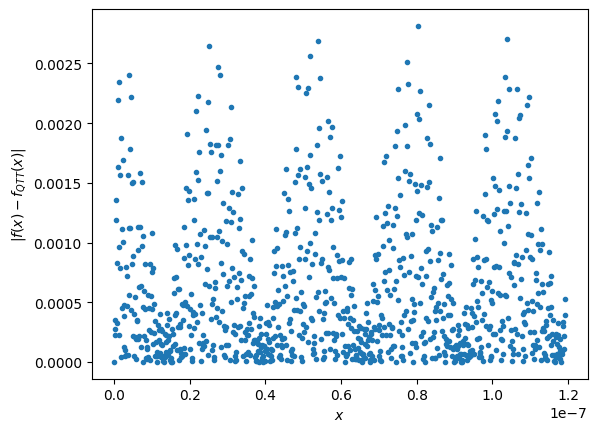

In [7]:
plt.plot(xs,[abs(a - b) for a, b in zip(fs, tts)], '.')
plt.xlabel(r"$x$")
plt.ylabel(r"$|f(x) - f_{QTT}(x)|$");

### Function evaluations

Our TCI algorithm does not call elements of the entire tensor, but constructs the TT (Tensor Train) from some elements chosen adaptively. On which points $x \in [0, 3]$ was the function evaluated to construct a QTT representation of the function $f(x)$? Let's plot f and the evaluated points together.

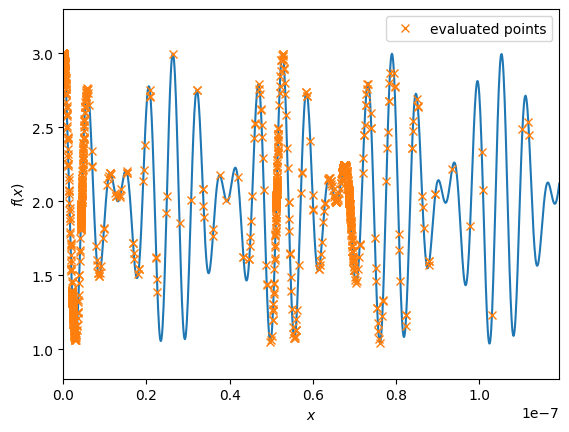

8115 sampled points


In [8]:
xs_evaluated = [x for x,y in fcaching.sampled.items()] 
fs_evaluated = [y for x,y in fcaching.sampled.items()]

plt.plot(xs, fs)
plt.plot(xs_evaluated, fs_evaluated, "x", label="evaluated points")
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(0, max(xs))
plt.ylim(0.8, 3.3)
plt.legend();
plt.show()

print(f'{len(fcaching.sampled)} sampled points')

## Example 2

We now consider the function:

$$
f(x) = \mathrm{sinc}(x)+3e^{-0.3(x-4)^2}\mathrm{sinc}(x-4) - \cos(4x)^2-2\mathrm{sinc}(x+10)e^{-0.6(x+9)} + 4 \cos(2x) e^{-|x+5|} + \frac{6}{x-11}+ \sqrt{(|x|)}\arctan(x/15)
$$

One can construct a QTT representation of this function on the domain $[-10, 10]$ using a quantics grid of size $2^\mathcal{R}$ ($\mathcal{R}=20$):


In [9]:
qgrid = xfacpy.QuanticsGrid(a=-10, b=10, nBit=20)  # build the quantics grid

# Function of interest
def f(x):
    return (
        np.sinc(x) + 3 * exp(-0.3 * (x - 4)**2) * np.sinc(x - 4) - cos(4 * x)**2 -
        2 * np.sinc(x + 10) * exp(-0.6 * (x + 9)) + 4 * cos(2 * x) * exp(-abs(x + 5)) +
        6 * 1 / (x - 11) + sqrt(abs(x)) * atan(x / 15))

args = xfacpy.TensorCI2Param()                      # fix the max bond dimension
args.bondDim = 15
ci = xfacpy.QTensorCI(f1d=f, qgrid=qgrid, args=args)  # construct a tci of the quantics tensor
while not ci.isDone():
    ci.iterate()

### Plot the convergence of the pivot error

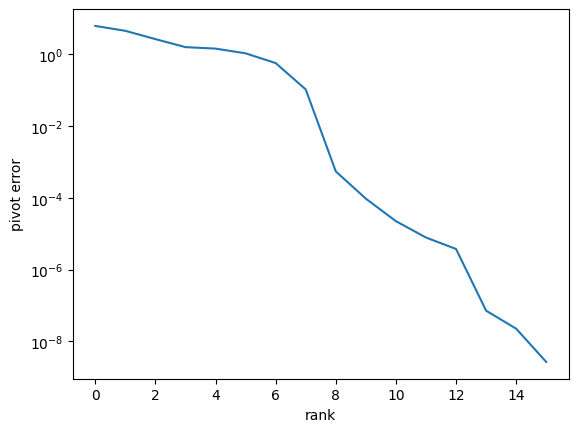

In [10]:
plt.xlabel("rank")
plt.ylabel("pivot error")
plt.yscale("log")
plt.plot(ci.pivotError);

### Plot the actual approximation of the function
As before the function can be plotted against the exact one. Note that the last point at $x = 10$ is not included, the quantics grid
runs only on interval $[-10, 10)$.

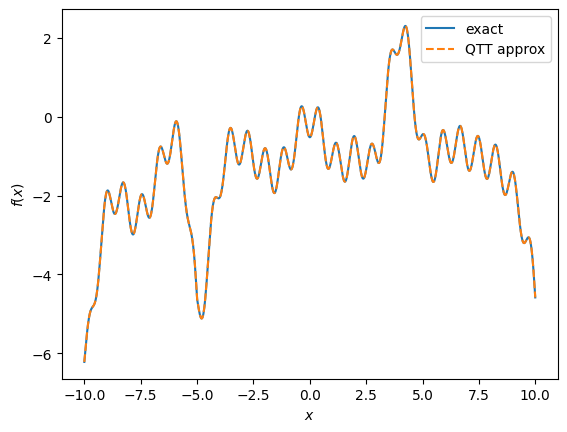

In [11]:
qtt = ci.get_qtt()  # the actual function approximating f
xs = np.linspace(-10, 10 - 2**(-20), 1000)

plt.plot(xs,[f(x) for x in xs], '-', label='exact')
plt.plot(xs,[qtt.eval([x]) for x in xs],'--', label='QTT approx')
plt.legend();
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.show()